# Web Traffic Time Series Forecasting

### Part1: Data Cleaning, Periodicity Analysis, and Topics. 

Data Download using Wikipediatrend Package and Kaggle Website. 

https://github.com/petermeissner/wikipediatrend

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [5]:
#key1=pd.read_csv('key_1.csv')
key2=pd.read_csv('key_2.csv')

In [3]:
#train1=pd.read_csv('train_1.csv')
train=pd.read_csv('train_2.csv')

In [6]:
print('Length key2', len(key2))
#print('Length key2', len(key2))
print('Length train2', len(train))
#print('Length train2', len(train2))

Length key2 8993906
Length train2 145063


In [8]:
print('days for prediction',len(key2)/len(train))
train.shape

days for prediction 62.0


(145063, 804)

In [9]:
train.head(2)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0


### Extract the Time From Columns Names
1. extract year, month, and days information  
2. extract the weekday(weekend) information (0 is Monday and 6 is Sunday)
3. extract days from the first day in the dataset 

In [10]:
columns=train.columns[1:]

from datetime import datetime,date
import calendar
year=[*map(lambda x: (datetime.strptime(x, '%Y-%m-%d')).year, columns)]
month=[*map(lambda x: (datetime.strptime(x, '%Y-%m-%d')).month, columns)]
day=[*map(lambda x: (datetime.strptime(x, '%Y-%m-%d')).day, columns)]
week=[*map(lambda x: (datetime.strptime(x, '%Y-%m-%d')).weekday(), columns)]

In [11]:
d1 = datetime.strptime(columns[0], "%Y-%m-%d")
d2 = datetime.strptime(columns[-1], "%Y-%m-%d")

In [12]:
pd_time= pd.DataFrame({'time': columns,'year': year,\
                       'month':month,'day':day,'weekday/end':week,\
                       'delta_days':np.arange((d2-d1).days+1)},\
                      columns=['time','year','month','day','weekday/end','delta_days'])

pd_time.head(2) # 0 is Monday and 6 is Sunday 

,time,year,month,day,weekday/end,delta_days
0,2015-07-01,2015,7,1,2,0
1,2015-07-02,2015,7,2,3,1


In [13]:
time=pd_time['delta_days']

In [1]:
#pd.isnull(train1).sum().sort_values(ascending=True).head(2)

In [14]:
#train1.index[value_count < 551*0.9]
#pd_time.to_csv('pd_time.csv',index=False)

### EDA (fill in the missing data, extract language, agent, access information from page urls)
1. if only less than 10% of the num of columns are valid values and continus NaNs, maybe the page does not exit
2. Extract the language and website information from the Page column. 

In [15]:
Page=train['Page']

In [16]:
# first use a function later find a simple way to extract all the information 
page_details = Page.str.extract\
(r'(?P<topic>.*)\_(?P<lang>.*).(?:wikipedia.org|wikimedia.org|mediawiki.org)\_(?P<access>.*)\_(?P<type>.*)')

In [17]:
train_new=pd.concat([train,page_details],axis=1,sort=False,join='inner')

In [18]:
train_new.shape

(145063, 808)

In [19]:
#value_count=train1.apply(lambda x: x.count(), axis=1)
train_new=train_new.fillna(0)#.drop(train1.index[value_count < 551*0.1]) #index=(value_count < 551*0.1)

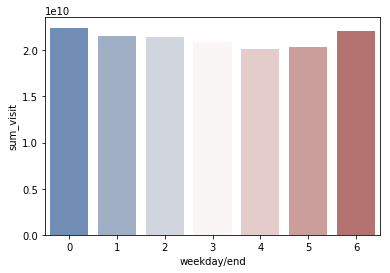

In [22]:
pd_time['sum_visit']=train_new[columns].sum().values
week_stat=pd_time.groupby(pd_time['weekday/end']).sum() #week_stat['sum_visit']
sns.barplot(x=week_stat.index,y=(week_stat['sum_visit']),palette="vlag")

Okay, until now, we have cleaned the data.

1) we fill in the NaN by using 0. 
2) formed a pd_time data frame with year, month, day and weekday/end information. 
3) extracted the language, access, agent, and topic information from Page url.  

Now let's look at an example of one page url. 

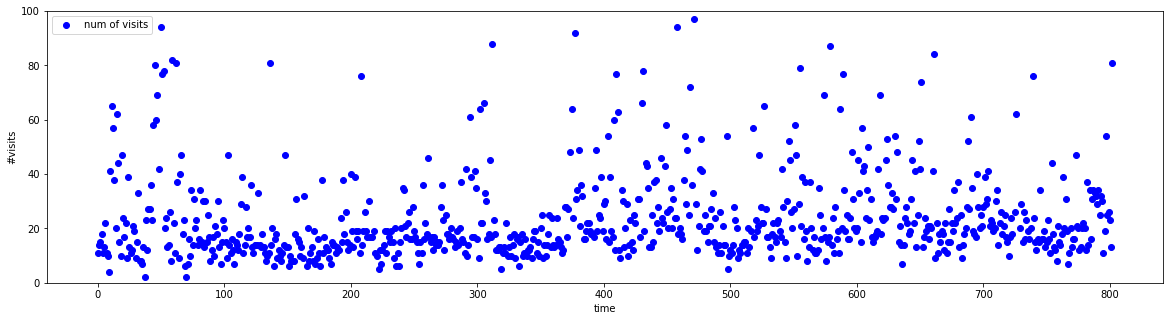

In [26]:
fig = plt.figure(figsize=(20,5))
plt.plot(time,train_new.iloc[1,1:804].values,'bo',label='num of visits')
plt.ylim(0,100)
plt.xlabel('time')
plt.ylabel('#visits')
plt.legend(loc='upper left')

### Analyze the Sum Web Traffic of Different Languages

We choose to use sum instead of mean visits as the metric.  

In [33]:
sum_lan=pd.DataFrame(train_new.groupby(train_new['lang']).sum())

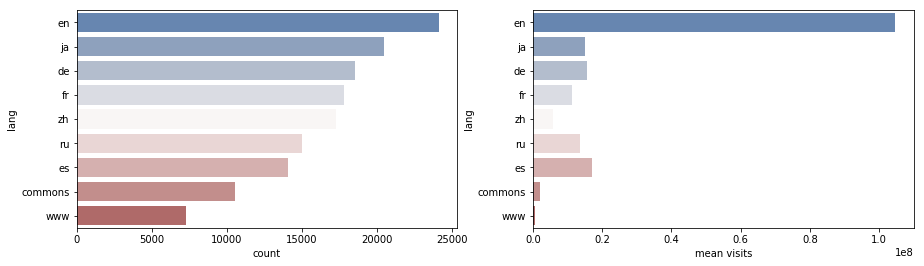

In [34]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(y='lang', data=train_new,
              order=train_new['lang'].value_counts().index,palette="vlag",ax=ax[0])

mean_visit=pd.DataFrame(sum_lan.mean(axis=1),columns=['mean visits'])
sns.barplot(y=mean_visit.index,x=mean_visit['mean visits'],palette="vlag",ax=ax[1],\
            order=train_new['lang'].value_counts().index)


1) There are most English pages. 
2) English Pages has the most mean visits across the time interval.  

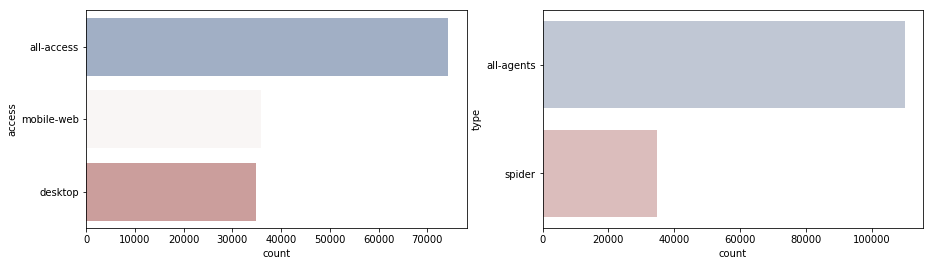

In [36]:
f, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(y='access', data=train_new,
              order=train_new['access'].value_counts().index,palette="vlag",ax=ax[0])
sns.countplot(y='type', data=train_new,
              order=train_new['type'].value_counts().index,palette="vlag",ax=ax[1])

### Averaged website visits according to languages. 

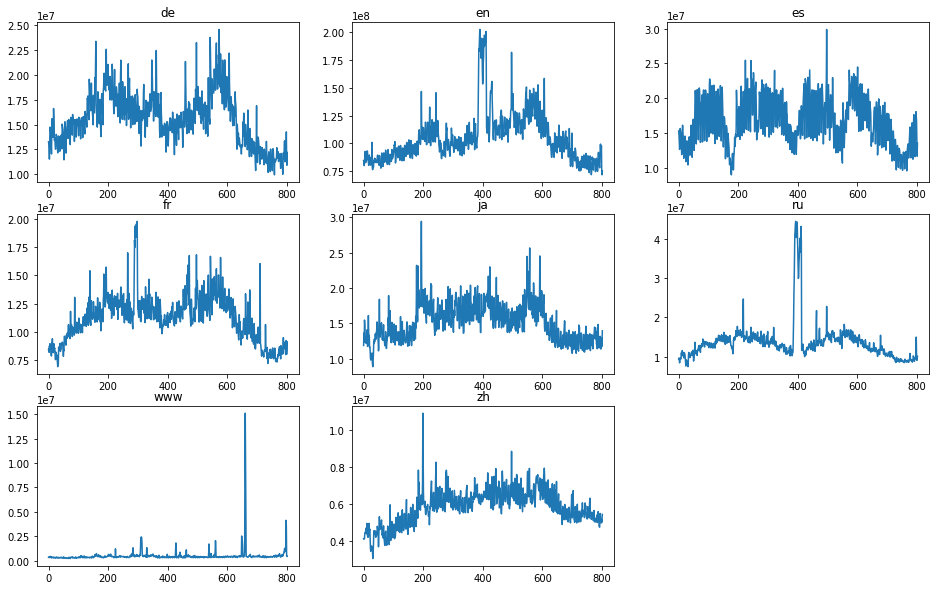

In [37]:
fig = plt.figure(figsize=[16, 10])
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(1, 9):
    ax = fig.add_subplot(3, 3, i)
    plt.plot(time,sum_lan.iloc[i,:].values)
    ax.set_title(sum_lan.index[i])
    #ax.set_xlabel('Time')
    #ax.set_ylable('Total Visits')

In [38]:
a=train_new[train_new['lang'] == 'en'].sample(n=10)

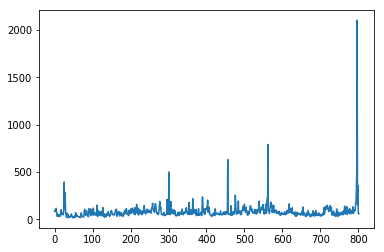

In [40]:
plt.plot(time,a.iloc[8,1:804])

### Periodicity 

In this section, i applied a commonly used astronomy method, Lomb–Scargle Periodogram, which is commonly used to analyze the time series data in astronomy (e.g., variable stars and exoplanets) to find the period in the web traffic data. For more details of this method: http://iopscience.iop.org/article/10.3847/1538-4365/aab766/meta. It is nice because it also works for unevenly sampled data. 

In [41]:
def cal_ls(time,data):
    from astropy.stats import LombScargle
    ls = LombScargle(time, data)  # convert time (yrs) to days
    frequency, power = ls.autopower(maximum_frequency=0.5,minimum_frequency=0.00274)
    periods = 1. / frequency # in days
    # find the best period
    best_period = periods[np.argmax(power)]
    print("period = {0}".format(best_period))

    probabilities = [0.01, 0.001, 0.0001]
    levels=ls.false_alarm_level(probabilities)
    #print(periods[power.argsort()[-10:]])
    return periods,power,levels

def plot_ls(periods,power,best_period1,best_period2,levels,string,ymax):
    
    phase1 = (time / best_period1) % 1
    phase2 = (time / best_period2) % 1
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    # PSD has a _LOT_ of elements. Rasterize it so it can be displayed as PDF
    ax[0].plot(periods, power, '-k', rasterized=True)

    ax[0].set(xlim=(1, 500), ylim=(0, ymax),
          xlabel='Period (days)',
          ylabel='Lomb-Scargle Power',
          title='Lomb-Scargle Periodogram'+' '+string)
    ax[0].set_xscale('log')

    ax[0].plot([0,500],[levels[0],levels[0]],'b-.')
    ax[0].plot([0,500],[levels[1],levels[1]],'b-.')
    ax[0].plot([0,500],[levels[2],levels[2]],'b-.')

    ax[1].plot(phase1, data, '.k')
    ax[1].set(xlabel='phase',
          ylabel='Total Num of Visits',
          title='Phased Data')
    ax[1].text(0.02, 0.9, "Period = {0:.2f} days".format(best_period1),
           transform=ax[1].transAxes)

    ax[2].plot(phase2, data, '.k')
    ax[2].set(xlabel='phase',
          ylabel='Total Num of Visits',
          title='Phased Data')
    #ax[1].invert_yaxis()
    ax[2].text(0.02, 0.9, "Period = {0:.2f} days".format(best_period2),
           transform=ax[2].transAxes)

#fig.savefig('fig02_LINEAR_PSD.pdf');

period = 364.9635036496351
period = 222.93383145979968
period = 6.998408691011356
period = 334.517910472663


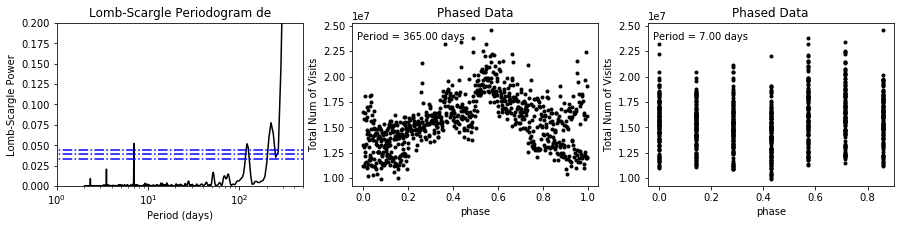

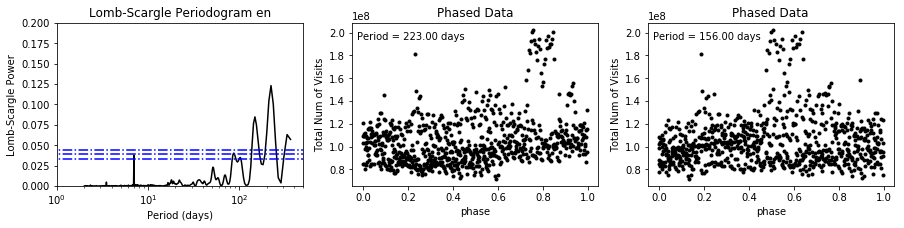

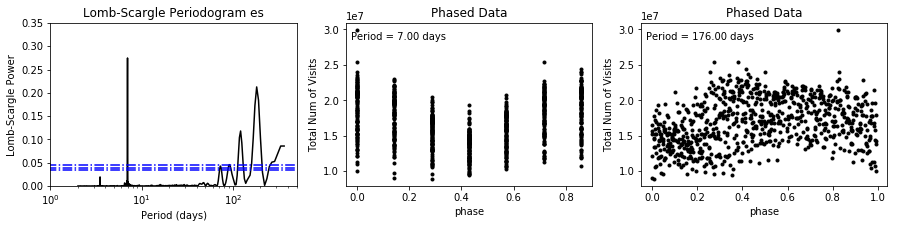

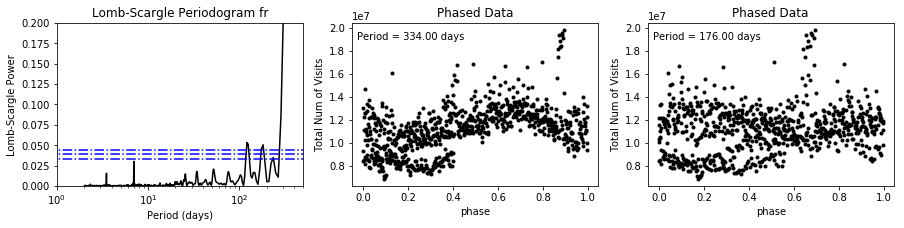

In [63]:
data=sum_lan.iloc[1,:].values ; lang=sum_lan.index[1]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,365,7,levels,lang,ymax=0.2)

data=sum_lan.iloc[2,:].values ; lang=sum_lan.index[2]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,223,156,levels,lang,ymax=0.2)

data=sum_lan.iloc[3,:].values ; lang=sum_lan.index[3]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,7,176,levels,lang,ymax=0.35)

data=sum_lan.iloc[4,:].values ; lang=sum_lan.index[4]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,334,176,levels,lang,ymax=0.2)

period = 334.517910472663
period = 148.58785951962767
period = 334.517910472663


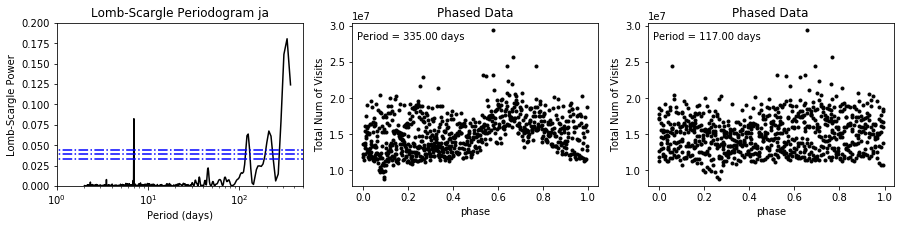

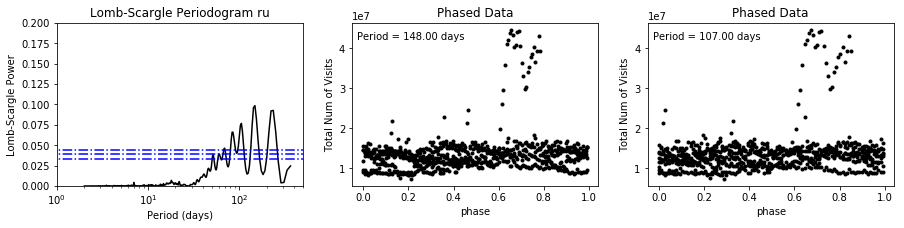

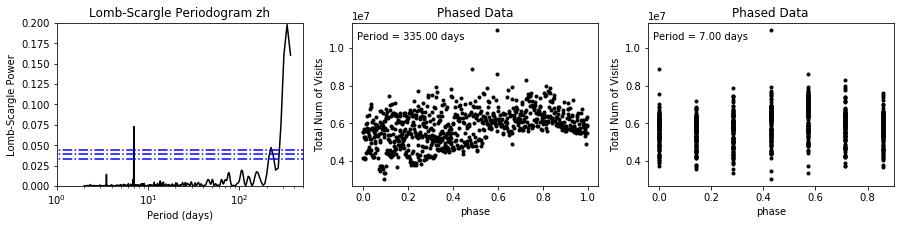

In [64]:
data=sum_lan.iloc[5,:].values ; lang=sum_lan.index[5]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,335,117,levels,lang,ymax=0.2)

data=sum_lan.iloc[6,:].values ; lang=sum_lan.index[6]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,148,107,levels,lang,ymax=0.2)

data=sum_lan.iloc[8,:].values ; lang=sum_lan.index[8]
periods,power,levels=cal_ls(time,data)
plot_ls(periods,power,335,7,levels,lang,ymax=0.2)


### Topics 
In total, there are 49174 topics. 

In [45]:
topics=train_new.groupby(train_new['topic']).count().Page.sort_values(ascending=False)

In [46]:
print('Total Number of Topics {} '.format(len(topics)))

Total Number of Topics 49174 


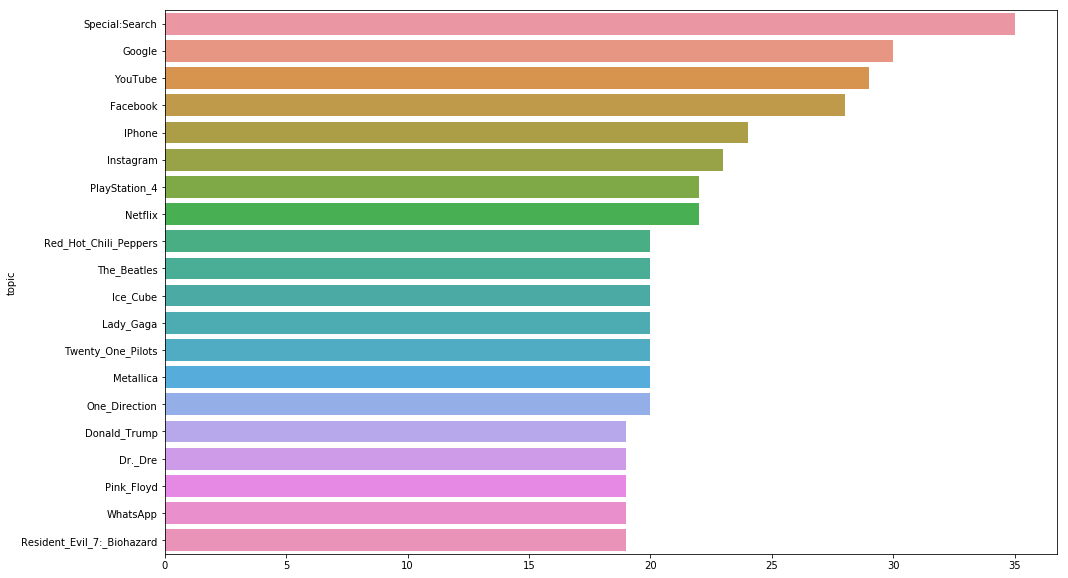

In [47]:
fig = plt.figure(figsize=[16, 10])
sns.barplot(y=topics.index[0:20], x=topics.values[0:20])

In [48]:
example_dp=train_new[train_new['topic'] == 'Deadpool'] # because the band starts in 2016 
#example_dp

In [50]:
example_dp.head(2)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,topic,lang,access,type
4780,Deadpool_fr.wikipedia.org_desktop_all-agents,304.0,337.0,1083.0,401.0,383.0,689.0,582.0,576.0,592.0,...,164.0,237.0,213.0,243.0,251.0,240.0,Deadpool,fr,desktop,all-agents
8908,Deadpool_en.wikipedia.org_desktop_all-agents,3678.0,8220.0,6540.0,4586.0,5504.0,6664.0,7473.0,7383.0,11810.0,...,1417.0,1353.0,1330.0,1531.0,1117.0,1150.0,Deadpool,en,desktop,all-agents


Deadpool was released in the United States on February 12, 2016

No handles with labels found to put in legend.


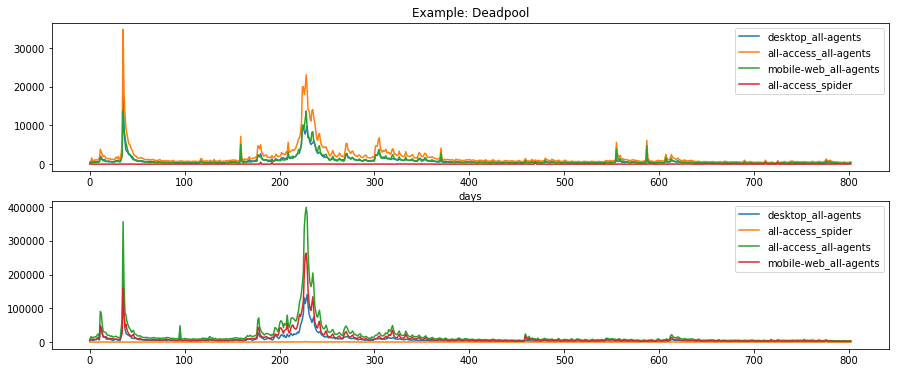

In [62]:
f, ax = plt.subplots(2, 1, figsize=(15, 6))

for i in example_dp.index:
    if train_new.iloc[i,805] == 'fr':
        ax[0].plot(time,train_new.iloc[i,1:804],\
                   label=train_new.iloc[i,806]+'_'+train_new.iloc[i,807])
    ax[0].legend()
    ax[0].set_title('Example: Deadpool')
    ax[0].set_xlabel('days')
    if train_new.iloc[i,805] == 'en':
        ax[1].plot(time,train_new.iloc[i,1:804],\
                   label=train_new.iloc[i,806]+'_'+train_new.iloc[i,807])
    ax[1].legend()    
#plt.ylim(0,20000)    

### Find that type and access is important 
all_access (agent) ~= sum(desktop + mobile_web)   
if type == spider, different from all-agents